<a href="https://colab.research.google.com/github/DjengoFang/Financial-Engineering-Ruppert-Matteson-/blob/main/Lab5.19.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm
import pylab as py
import seaborn as sns

In [93]:
!pip install fitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
!pip install numdifftools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [95]:
from fitter import Fitter, get_common_distributions, get_distributions

In [96]:
import numdifftools as ndt

In [97]:
url = 'https://raw.githubusercontent.com/DjengoFang/Financial-Engineering-Ruppert-Matteson-/main/datasets/EuStockMarkets.csv'
data = pd.read_csv(url)
data.head(5)

,DAX,SMI,CAC,FTSE
0,1628.75,1678.1,1772.8,2443.6
1,1613.63,1688.5,1750.5,2460.2
2,1606.51,1678.6,1718.0,2448.2
3,1621.04,1684.1,1708.1,2470.4
4,1618.16,1686.6,1723.1,2484.7


In [98]:
DAX_log = np.diff(np.log(data['DAX']))
DAX_log

array([-0.00932655, -0.00442218,  0.00900379, ...,  0.01895731,
       -0.0059412 ,  0.02192215])

# Problem 6

In [99]:
x = DAX_log

def log_like(parameters):
  f = -np.sum(stats.t.logpdf(x,parameters[2],parameters[0],parameters[1]))
  return f

In [100]:
start = np.array([np.mean(x), np.std(x), 4])
bnds = ((-0.1,0.1), (0.001, 1), (2.1, 20))
log_like_model = opt.minimize(fun=log_like, x0=start, method='L-BFGS-B',bounds=bnds) 

## Optimize Parameters

In [101]:
parm = log_like_model.x
print(parm)

[7.84723297e-04 7.53880850e-03 4.19454353e+00]


In [102]:
print(log_like_model.hess_inv.todense())

[[ 2.34195253e-02 -3.16053081e-03 -2.10621112e+01]
 [-3.16053081e-03  7.08311583e-03 -6.44295406e+00]
 [-2.10621112e+01 -6.44295406e+00  3.18947440e+04]]


In [103]:
np.linalg.inv(log_like_model.hess_inv.todense())

array([[2.21982621e+06, 2.84705132e+06, 2.04101489e+03],
       [2.84705132e+06, 3.65167559e+06, 2.61775074e+03],
       [2.04101489e+03, 2.61775074e+03, 1.87664558e+00]])

In [104]:
np.sqrt(np.diag(np.linalg.inv(log_like_model.hess_inv.todense())))

array([1.48990812e+03, 1.91093579e+03, 1.36990714e+00])

## AIC  Akaike information criterion

In [105]:
minus_logL_std = log_like(parm)
print(minus_logL_std)

-5983.321865930821


In [106]:
AIC_std = 2*minus_logL_std + 2*len(parm)
print(AIC_std)

-11960.643731861643


# Problem 7

In [107]:
!pip install sstudentt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [108]:
from sstudentt import SST

In [109]:
def log_like_SST(parameters):
  dist = SST(mu = parameters[0], sigma = parameters[1], nu = parameters[2], tau = parameters[3])
  f = -np.sum(np.log(dist.p(x)))
  return f

In [110]:
start = np.array([np.mean(x), np.std(x), 4, 1])
bnds = ((-0.1,0.1), (0.001, 1), (2.1, 20), (0.25, 4))
log_like_model = opt.minimize(fun=log_like_SST, x0=start, method='L-BFGS-B',bounds=bnds) 

/usr/local/lib/python3.8/dist-packages/sstudentt/sstudentt.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  self.m = ((2 * self.tau ** 0.5) * (self.nu - self.nu ** -1)) / (
/usr/local/lib/python3.8/dist-packages/sstudentt/sstudentt.py:36: RuntimeWarning: invalid value encountered in sqrt
  self.mu_0 = self.mu - (self.sigma * self.m / np.sqrt(self.s2))
/usr/local/lib/python3.8/dist-packages/sstudentt/sstudentt.py:37: RuntimeWarning: invalid value encountered in sqrt
  self.sigma_0 = self.sigma / np.sqrt(self.s2)


## Optimize Parameters

In [111]:
parm2 = log_like_model.x
print(parm2)

[6.52041748e-04 1.02980657e-02 4.00000000e+00 1.00000000e+00]


## AIC  Akaike information criterion

In [112]:
minus_logL_std = log_like(parm2)
print(minus_logL_std)
AIC_std = 2*minus_logL_std + 2*len(parm2)
print(AIC_std)

-5881.7649996542705
-11755.529999308541


# Problem 8
## TKDE
### Transform by Student-T distribution

In [113]:
df = parm[2]
loc = parm[0]
scale = parm[1]
print(df, loc, scale)

4.194543526907325 0.0007847232974708594 0.007538808498785821


In [114]:
x1 = stats.t.cdf(x, df=df, loc=loc, scale=scale)
x2 = stats.norm.ppf(x1)

In [115]:
eval_points1 = np.linspace(np.min(x), np.max(x), num=1000)
eval_points2 = np.linspace(np.min(x2), np.max(x2), num=1000)
kde1 = stats.gaussian_kde(x)
d1y = kde1.pdf(eval_points1)

kde2 = stats.gaussian_kde(x2)
d2x = stats.norm.cdf(eval_points2)
d2y = kde2.pdf(eval_points2)

In [116]:
ginvx = stats.t.ppf(d2x, df=df, loc=loc, scale=scale)
gprime_num = stats.t.pdf(ginvx, df=df, loc=loc, scale=scale)
gprime_den =  stats.norm.pdf(stats.norm.ppf(stats.t.cdf(ginvx, df=df, loc=loc, scale=scale)))
gprime = gprime_num / gprime_den

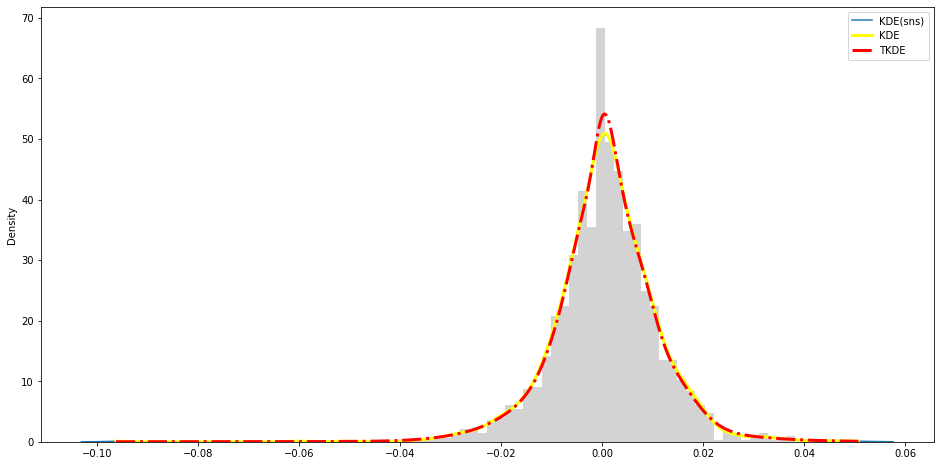

In [117]:
plt.figure(figsize=(16,8))
plt.hist(x, bins='auto',density=True, color = "lightgrey")
sns.kdeplot(x)
plt.plot(eval_points1, d1y, linewidth=3, color = "yellow")
plt.plot(ginvx, d2y * gprime, linestyle="dashdot", linewidth=3, color = "red")
plt.legend(['KDE(sns)', 'KDE', 'TKDE'])

# Problem 9

(0.0, 25.0)

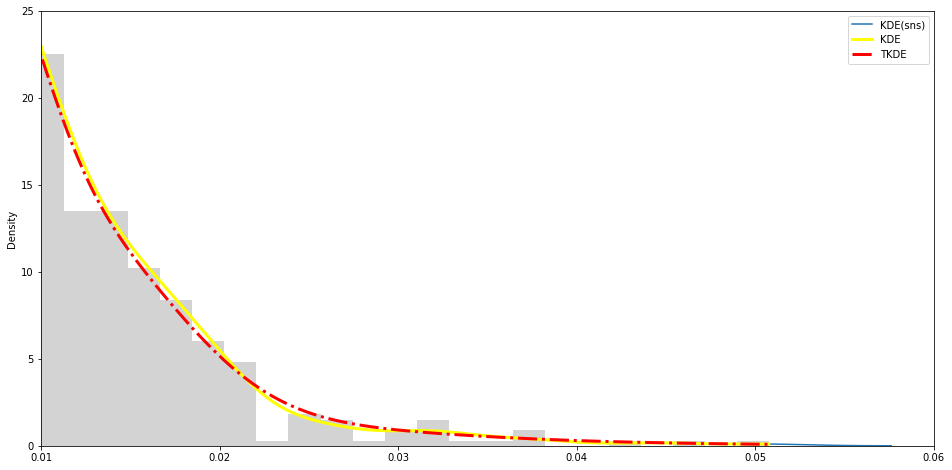

In [118]:
plt.figure(figsize=(16,8))
plt.hist(x, bins='auto',density=True, color = "lightgrey")
sns.kdeplot(x)
plt.plot(eval_points1, d1y, linewidth=3, color = "yellow")
plt.plot(ginvx, d2y * gprime, linestyle="dashdot", linewidth=3, color = "red")
plt.legend(['KDE(sns)', 'KDE', 'TKDE'])
plt.xlim(0.01, 0.06)
plt.ylim(0, 25)

# Problem 10

In [119]:
FTSE_log = np.diff(np.log(data['FTSE']))
FTSE_log

array([ 0.00677029, -0.00488959,  0.00902702, ...,  0.00539698,
       -0.01154528,  0.01022626])

In [120]:
def log_like_SST2(parameters):
  dist = SST(mu = parameters[0], sigma = parameters[1], nu = parameters[2], tau = parameters[3])
  f = -np.sum(np.log(dist.p(FTSE_log)))
  return f

In [121]:
start = np.array([np.mean(FTSE_log), np.std(FTSE_log), 4, 1])
log_like_model2 = opt.minimize(fun=log_like_SST2, x0=start, method='L-BFGS-B') 

/usr/local/lib/python3.8/dist-packages/sstudentt/sstudentt.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  self.m = ((2 * self.tau ** 0.5) * (self.nu - self.nu ** -1)) / (
/usr/local/lib/python3.8/dist-packages/sstudentt/sstudentt.py:36: RuntimeWarning: invalid value encountered in sqrt
  self.mu_0 = self.mu - (self.sigma * self.m / np.sqrt(self.s2))
/usr/local/lib/python3.8/dist-packages/sstudentt/sstudentt.py:37: RuntimeWarning: invalid value encountered in sqrt
  self.sigma_0 = self.sigma / np.sqrt(self.s2)


## Optimize Parameters

In [122]:
parm3 = log_like_model2.x
print(parm3)

[4.31985077e-04 7.95558721e-03 4.00000000e+00 1.00000000e+00]


## AIC  Akaike information criterion

In [123]:
minus_logL_std = log_like(parm2)
print("minus_logL_std = "+str(minus_logL_std))
AIC_std = 2*minus_logL_std + 2*len(parm2)
print("AIC_std = "+str(AIC_std))

minus_logL_std = -5881.7649996542705
AIC_std = -11755.529999308541


## BIC Bayesian information criterion

In [124]:
BIC_std = 2*minus_logL_std + math.log(len(FTSE_log))*len(parm2)
print("n = "+str(len(FTSE_log)))
print("log(n) = "+str(math.log(len(FTSE_log))))
print("BIC_std = "+str(BIC_std))

n = 1859
log(n) = 7.527793987721444
BIC_std = -11733.418823357655
